In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
import tensorflow as tf
import torch
import torch.nn as nn
from transformers import GPT2Tokenizer, GPT2Model
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import string
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from transformers import BertTokenizer, BertModel

2025-04-15 02:28:51.618094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744684131.842693      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744684131.916640      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df=pd.read_csv('/kaggle/input/toxic-language/DATASET/train.csv')
test=pd.read_csv('/kaggle/input/toxic-language/DATASET/test.csv')

In [3]:
df = df[df['feedback_text'].str.match(r'.*[a-zA-Z].*', na=False)]

# Pre-processing

In [6]:
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

all_text = ' '.join(df['feedback_text'].dropna().astype(str))
processed_text = preprocess_text(all_text)

words = processed_text.split()
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word not in stop_words and len(word) > 2]

In [8]:
stemmer = PorterStemmer()
df['processed_text'] = df['feedback_text'].apply(preprocess_text)
df['feedback_text'] = df['feedback_text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

In [9]:
class BengaliTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['feedback_text'], df['toxic'], test_size=0.3, random_state=42)

# GPT 2

In [8]:
class HybridGPT2Model(nn.Module):
    def __init__(self, num_labels):
        super(HybridGPT2Model, self).__init__()
        self.gpt2 = GPT2Model.from_pretrained("gpt2")  # Change this to a Bengali GPT-2 model if available
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.gpt2.config.n_embd, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.gpt2(input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state[:, -1, :]  # Get the last token's hidden state
        hidden_states = self.dropout(hidden_states)
        logits = self.classifier(hidden_states)
        return logits

In [10]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2") 
tokenizer.pad_token = tokenizer.eos_token 

train_dataset = BengaliTextDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = BengaliTextDataset(X_test.tolist(), y_test.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
num_labels = 2
model_GPT = HybridGPT2Model(num_labels=num_labels)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

epochs = 10
for epoch in range(epochs):
    model_GPT.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        logits = model_Bert(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        _, preds = torch.max(logits, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    train_accuracy = correct_predictions / total_predictions

    model_Bert.eval()
    correct_test_predictions = 0
    total_test_predictions = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Epoch {epoch + 1}/{epochs} - Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model_Bert(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(logits, dim=1)
            correct_test_predictions += (preds == labels).sum().item()
            total_test_predictions += labels.size(0)

    test_accuracy = correct_test_predictions / total_test_predictions

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, "
          f"Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Epoch 1/20: 100%|██████████| 374/374 [02:50<00:00,  2.20it/s]


Epoch [1/20], Loss: 0.2284, Training Accuracy: 0.9178


Epoch 2/20: 100%|██████████| 374/374 [02:48<00:00,  2.22it/s]


Epoch [2/20], Loss: 0.1322, Training Accuracy: 0.9507


Epoch 3/20: 100%|██████████| 374/374 [02:48<00:00,  2.22it/s]


Epoch [3/20], Loss: 0.1035, Training Accuracy: 0.9599


Epoch 4/20: 100%|██████████| 374/374 [02:48<00:00,  2.22it/s]


Epoch [4/20], Loss: 0.0869, Training Accuracy: 0.9669


Epoch 5/20: 100%|██████████| 374/374 [02:48<00:00,  2.22it/s]


Epoch [5/20], Loss: 0.0586, Training Accuracy: 0.9773


Epoch 6/20: 100%|██████████| 374/374 [02:48<00:00,  2.22it/s]


Epoch [6/20], Loss: 0.0406, Training Accuracy: 0.9839


Epoch 7/20: 100%|██████████| 374/374 [02:48<00:00,  2.22it/s]


Epoch [7/20], Loss: 0.0330, Training Accuracy: 0.9879


Epoch 8/20: 100%|██████████| 374/374 [02:48<00:00,  2.22it/s]


Epoch [8/20], Loss: 0.0209, Training Accuracy: 0.9925


Epoch 9/20: 100%|██████████| 374/374 [02:48<00:00,  2.22it/s]


Epoch [9/20], Loss: 0.0172, Training Accuracy: 0.9937


Epoch 10/20: 100%|██████████| 374/374 [02:48<00:00,  2.22it/s]


Epoch [10/20], Loss: 0.0088, Training Accuracy: 0.9972


Epoch 11/20: 100%|██████████| 374/374 [02:48<00:00,  2.22it/s]


Epoch [11/20], Loss: 0.0130, Training Accuracy: 0.9955


Epoch 12/20: 100%|██████████| 374/374 [02:48<00:00,  2.22it/s]


Epoch [12/20], Loss: 0.0084, Training Accuracy: 0.9970


Epoch 13/20: 100%|██████████| 374/374 [02:48<00:00,  2.22it/s]


Epoch [13/20], Loss: 0.0117, Training Accuracy: 0.9961


Epoch 14/20: 100%|██████████| 374/374 [02:48<00:00,  2.22it/s]


Epoch [14/20], Loss: 0.0072, Training Accuracy: 0.9969


Epoch 15/20: 100%|██████████| 374/374 [02:48<00:00,  2.22it/s]


Epoch [15/20], Loss: 0.0070, Training Accuracy: 0.9973


Epoch 16/20:  77%|███████▋  | 289/374 [02:10<00:38,  2.21it/s]

# BERT

In [11]:
class BengaliBERTModel(nn.Module):
    def __init__(self, num_labels):
        super(BengaliBERTModel, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-multilingual-cased")  # Change this to a Bengali-specific BERT model if available
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state[:, 0, :]  # Get the [CLS] token's hidden state
        hidden_states = self.dropout(hidden_states)
        logits = self.classifier(hidden_states)
        return logits


In [14]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")  # Change if necessary
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.pad_token='[PAD]'
                          
train_dataset = BengaliTextDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = BengaliTextDataset(X_test.tolist(), y_test.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [16]:
num_labels =2
model_Bert = BengaliBERTModel(num_labels=num_labels)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_Bert.to(device)

optimizer = torch.optim.AdamW(model_Bert.parameters(), lr=2e-5)

epochs = 10
for epoch in range(epochs):
    model_Bert.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        logits = model_Bert(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        _, preds = torch.max(logits, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    train_accuracy = correct_predictions / total_predictions

    model_Bert.eval()
    correct_test_predictions = 0
    total_test_predictions = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Epoch {epoch + 1}/{epochs} - Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model_Bert(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(logits, dim=1)
            correct_test_predictions += (preds == labels).sum().item()
            total_test_predictions += labels.size(0)

    test_accuracy = correct_test_predictions / total_test_predictions

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, "
          f"Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Epoch 1/10 - Testing: 100%|██████████| 161/161 [00:21<00:00,  7.42it/s]


Epoch [1/10], Loss: 0.2231, Training Accuracy: 0.9155, Test Accuracy: 0.9424


Epoch 2/10 - Testing: 100%|██████████| 161/161 [00:21<00:00,  7.41it/s]


Epoch [2/10], Loss: 0.1322, Training Accuracy: 0.9495, Test Accuracy: 0.9459


Epoch 3/10 - Testing: 100%|██████████| 161/161 [00:21<00:00,  7.41it/s]


Epoch [3/10], Loss: 0.0874, Training Accuracy: 0.9666, Test Accuracy: 0.9500


Epoch 4/10 - Testing: 100%|██████████| 161/161 [00:21<00:00,  7.40it/s]


Epoch [4/10], Loss: 0.0584, Training Accuracy: 0.9773, Test Accuracy: 0.9479


Epoch 5/10 - Testing: 100%|██████████| 161/161 [00:21<00:00,  7.40it/s]


Epoch [5/10], Loss: 0.0381, Training Accuracy: 0.9864, Test Accuracy: 0.9465


Epoch 6/10 - Testing: 100%|██████████| 161/161 [00:21<00:00,  7.38it/s]


Epoch [6/10], Loss: 0.0272, Training Accuracy: 0.9906, Test Accuracy: 0.9496


Epoch 7/10 - Testing: 100%|██████████| 161/161 [00:21<00:00,  7.43it/s]


Epoch [7/10], Loss: 0.0240, Training Accuracy: 0.9918, Test Accuracy: 0.9498


Epoch 8/10 - Testing: 100%|██████████| 161/161 [00:21<00:00,  7.44it/s]


Epoch [8/10], Loss: 0.0113, Training Accuracy: 0.9970, Test Accuracy: 0.9492


Epoch 9/10 - Testing: 100%|██████████| 161/161 [00:21<00:00,  7.45it/s]


Epoch [9/10], Loss: 0.0119, Training Accuracy: 0.9963, Test Accuracy: 0.9399


Epoch 10/10 - Testing: 100%|██████████| 161/161 [00:21<00:00,  7.43it/s]

Epoch [10/10], Loss: 0.0054, Training Accuracy: 0.9982, Test Accuracy: 0.9328


In [21]:
model_Bert.eval()
all_predictions = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluation"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        logits = model_Bert(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(logits, dim=1)  # Get probabilities
        positive_probs = probs[:, 1]  # Probability of positive class (1)

        _, preds = torch.max(probs, dim=1)

        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(positive_probs.cpu().numpy())


Evaluation: 100%|██████████| 161/161 [00:21<00:00,  7.46it/s]


Accuracy: 0.9328
Precision: 0.6598
Recall: 0.8356
F1 Score: 0.7374


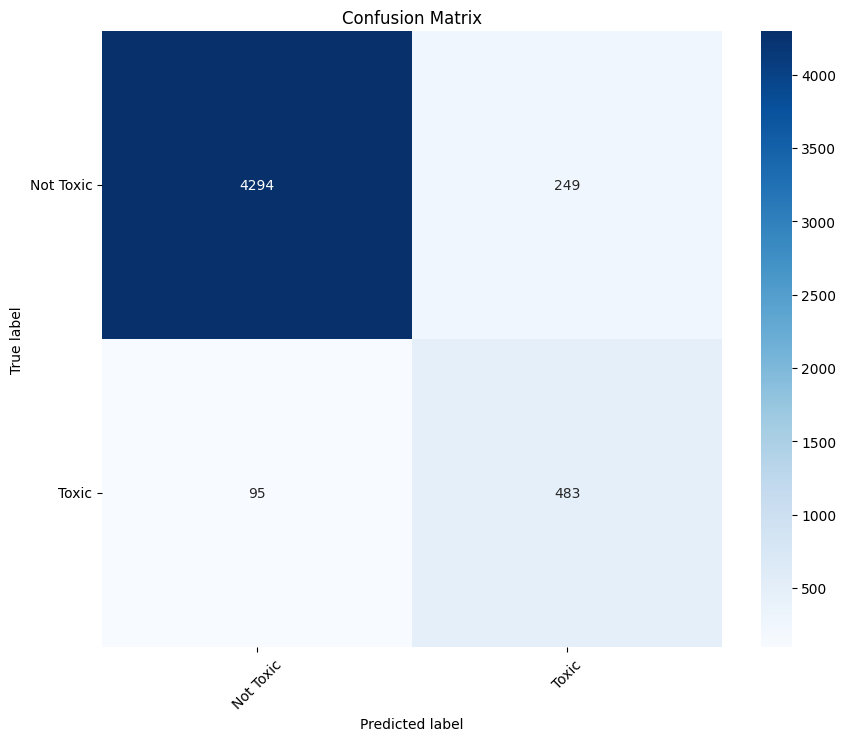

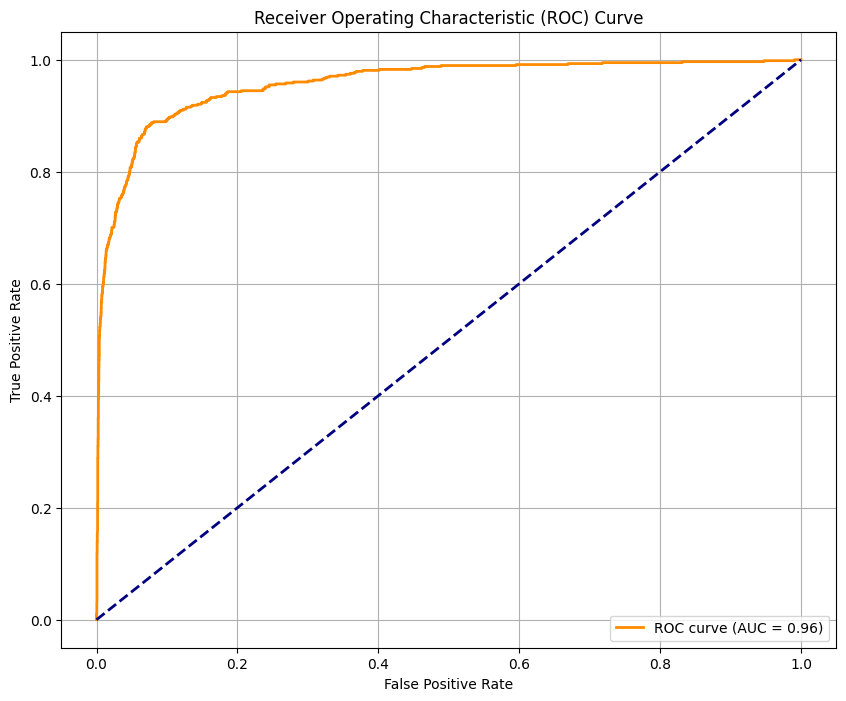

In [22]:
accuracy = accuracy_score(all_labels, all_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')
cm = confusion_matrix(all_labels, all_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Toxic', 'Toxic'],
            yticklabels=['Not Toxic', 'Toxic'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
